<a href="https://colab.research.google.com/github/abstractguy/crypto_bot/blob/master/crypto_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cryptocurrency trading bot.

Hardcoded parameters.

In [0]:
symbol = 'BTCUSDT'
period = '15 minutes ago UTC'
interval = '1m'
api_key = 'yoyoyo'
api_secret = 'yeyeye'

Installs.

In [2]:
!pip install python-binance --upgrade --no-cache-dir

Requirement already up-to-date: python-binance in /usr/local/lib/python3.6/dist-packages (0.7.5)


Library imports.

In [0]:
%matplotlib inline

from binance.client import Client
from binance.enums import *
from binance.exceptions import BinanceAPIException

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

Function definitions.

In [0]:
def heikin_ashi(df):
    heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['Open', 'High', 'Low', 'Close'])
    heikin_ashi_df['Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4

    for i in range(len(df)):
        if i == 0:
            heikin_ashi_df.iat[0, 0] = df['Open'].iloc[0]
        else:
            heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i - 1, 0] + heikin_ashi_df.iat[i - 1, 3]) / 2

    heikin_ashi_df['High'] = heikin_ashi_df.loc[:, ['Open', 'Close']].join(df['High']).max(axis=1)
    heikin_ashi_df['Low'] = heikin_ashi_df.loc[:, ['Open', 'Close']].join(df['Low']).min(axis=1)

    return heikin_ashi_df

def make_buy(quantity, milliseconds=1000):
    client.order_market_buy(symbol=symbol, 
                            quantity=quantity, 
                            quoteOrderQty=1, 
                            recvWindow=milliseconds)

def make_sell(quantity, milliseconds=1000):
    client.order_market_sell(symbol=symbol, 
                             quantity=quantity, 
                             quoteOrderQty=1, 
                             recvWindow=milliseconds)

Download cryptocurrency symbol data.

In [5]:
client = Client(api_key, api_secret)

dataset_downloaded = \
    client.get_historical_klines(symbol='BTCUSDT', 
                                 interval=interval, 
                                 start_str=period)

dataset_downloaded = pd.DataFrame(dataset_downloaded, 
                                  columns=['time', 
                                           'Open', 
                                           'High', 
                                           'Low', 
                                           'Close', 
                                           'Volume', 
                                           'Close time', 
                                           'Quote asset volume', 
                                           'Number of trades', 
                                           'Taker buy base asset volume', 
                                           'Taker buy quote asset volume', 
                                           'Ignore'])

four_hours = 14400
milliseconds = 1000

dataset_downloaded['time'] = \
    dataset_downloaded['time'].apply(lambda timestamp: \
                                     datetime.datetime.fromtimestamp((timestamp / \
                                                                      milliseconds) - \
                                                                     four_hours))

dataset_downloaded = dataset_downloaded[['time', 
                                         'Open', 
                                         'High', 
                                         'Low', 
                                         'Close', 
                                         'Volume', 
                                         'Number of trades']]

dataset_downloaded.set_index('time', inplace=True)
dataset_downloaded

,Open,High,Low,Close,Volume,Number of trades
time,,,,,,
2020-03-17 22:27:00,5348.34000000,5349.14000000,5345.67000000,5346.00000000,10.55592000,135
2020-03-17 22:28:00,5346.00000000,5346.76000000,5345.67000000,5345.68000000,8.23795400,104
2020-03-17 22:29:00,5345.67000000,5349.94000000,5345.67000000,5349.70000000,7.65812800,106
2020-03-17 22:30:00,5349.71000000,5359.60000000,5348.96000000,5358.71000000,87.12628800,385
2020-03-17 22:31:00,5359.62000000,5359.69000000,5355.49000000,5358.09000000,18.16216700,182
2020-03-17 22:32:00,5358.10000000,5359.69000000,5357.16000000,5358.99000000,16.30829200,176
2020-03-17 22:33:00,5358.99000000,5374.88000000,5358.99000000,5372.32000000,39.28914700,337
2020-03-17 22:34:00,5371.33000000,5372.02000000,5363.34000000,5366.71000000,47.73277900,295
2020-03-17 22:35:00,5365.73000000,5368.31000000,5360.78000000,5361.60000000,11.71105200,174


Download testing area -->

<-- End of download testing area.

*** To avoid downloading multiple times, restart here. ***

In [6]:
dataset = dataset_downloaded.copy()
dataset

,Open,High,Low,Close,Volume,Number of trades
time,,,,,,
2020-03-17 22:27:00,5348.34000000,5349.14000000,5345.67000000,5346.00000000,10.55592000,135
2020-03-17 22:28:00,5346.00000000,5346.76000000,5345.67000000,5345.68000000,8.23795400,104
2020-03-17 22:29:00,5345.67000000,5349.94000000,5345.67000000,5349.70000000,7.65812800,106
2020-03-17 22:30:00,5349.71000000,5359.60000000,5348.96000000,5358.71000000,87.12628800,385
2020-03-17 22:31:00,5359.62000000,5359.69000000,5355.49000000,5358.09000000,18.16216700,182
2020-03-17 22:32:00,5358.10000000,5359.69000000,5357.16000000,5358.99000000,16.30829200,176
2020-03-17 22:33:00,5358.99000000,5374.88000000,5358.99000000,5372.32000000,39.28914700,337
2020-03-17 22:34:00,5371.33000000,5372.02000000,5363.34000000,5366.71000000,47.73277900,295
2020-03-17 22:35:00,5365.73000000,5368.31000000,5360.78000000,5361.60000000,11.71105200,174


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



,Open,High,Low,Close
2020-03-17 22:27:00,5348.34,5349.140000,5345.670000,5347.2875
2020-03-17 22:28:00,5347.81,5347.813750,5345.670000,5346.0275
2020-03-17 22:29:00,5346.92,5349.940000,5345.670000,5347.7450
2020-03-17 22:30:00,5347.33,5359.600000,5347.332813,5354.2450
2020-03-17 22:31:00,5350.79,5359.690000,5350.788906,5358.2225
2020-03-17 22:32:00,5354.51,5359.690000,5354.505703,5358.4850
2020-03-17 22:33:00,5356.5,5374.880000,5356.495352,5366.2950
2020-03-17 22:34:00,5361.4,5372.020000,5361.395176,5368.3500
2020-03-17 22:35:00,5364.87,5368.310000,5360.780000,5364.1050
2020-03-17 22:36:00,5364.49,5364.488794,5357.900000,5360.3000


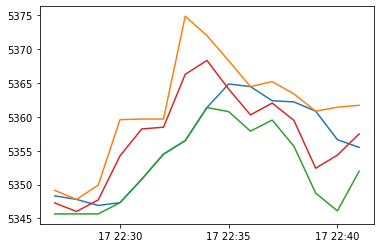

In [7]:
dataset = dataset.tz_localize(tz=None, ambiguous='infer')
heikin_ashi_dataset = dataset[['Open', 'High', 'Low', 'Close']].copy().astype('float')
heikin_ashi_dataset = heikin_ashi(heikin_ashi_dataset)
plt.plot(heikin_ashi_dataset)
heikin_ashi_dataset

In [8]:
fig = go.Figure(data=[go.Candlestick(x=heikin_ashi_dataset.index.to_series(), 
                                     open=heikin_ashi_dataset['Open'], 
                                     high=heikin_ashi_dataset['High'], 
                                     low=heikin_ashi_dataset['Low'], 
                                     close=heikin_ashi_dataset['Close'])])

fig.show()

2020-03-17 22:27:00    0
2020-03-17 22:28:00    0
2020-03-17 22:29:00    1
2020-03-17 22:30:00    1
2020-03-17 22:31:00    1
2020-03-17 22:32:00    1
2020-03-17 22:33:00    1
2020-03-17 22:34:00    1
2020-03-17 22:35:00    0
2020-03-17 22:36:00    0
2020-03-17 22:37:00    0
2020-03-17 22:38:00    0
2020-03-17 22:39:00    0
2020-03-17 22:40:00    0
2020-03-17 22:41:00    1
dtype: int64

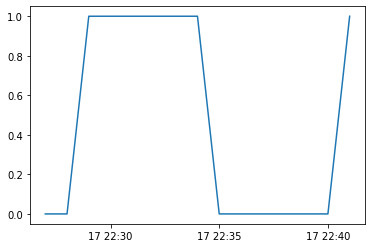

In [9]:
latent_trend = ((heikin_ashi_dataset['Close'] - heikin_ashi_dataset['Open']) > 0).astype(int)
plt.plot(latent_trend)
latent_trend

2020-03-17 22:27:00    0
2020-03-17 22:28:00    0
2020-03-17 22:29:00    0
2020-03-17 22:30:00    0
2020-03-17 22:31:00    0
2020-03-17 22:32:00    0
2020-03-17 22:33:00    0
2020-03-17 22:34:00    0
2020-03-17 22:35:00    0
2020-03-17 22:36:00    0
2020-03-17 22:37:00    0
2020-03-17 22:38:00    0
2020-03-17 22:39:00    0
2020-03-17 22:40:00    0
2020-03-17 22:41:00    0
dtype: int64

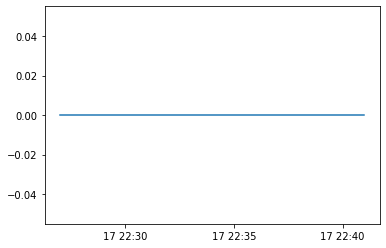

In [10]:
latest_trend = (heikin_ashi_dataset['High'] == heikin_ashi_dataset['Close']).astype(int)
plt.plot(latest_trend)
latest_trend

2020-03-17 22:27:00    0
2020-03-17 22:28:00    0
2020-03-17 22:29:00    0
2020-03-17 22:30:00    0
2020-03-17 22:31:00    0
2020-03-17 22:32:00    0
2020-03-17 22:33:00    0
2020-03-17 22:34:00    0
2020-03-17 22:35:00    0
2020-03-17 22:36:00    0
2020-03-17 22:37:00    0
2020-03-17 22:38:00    0
2020-03-17 22:39:00    0
2020-03-17 22:40:00    0
2020-03-17 22:41:00    0
dtype: int64

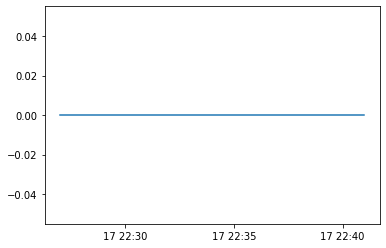

In [11]:
buy_position = latent_trend & latest_trend
plt.plot(buy_position)
buy_position